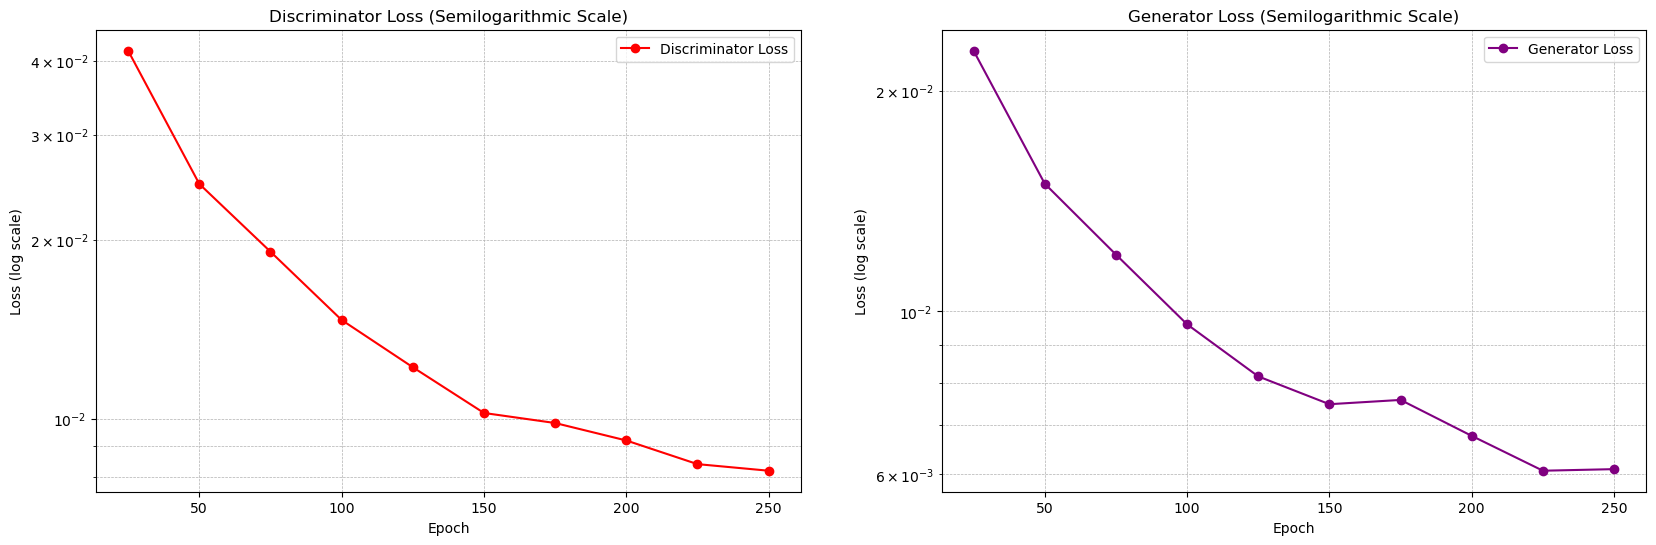

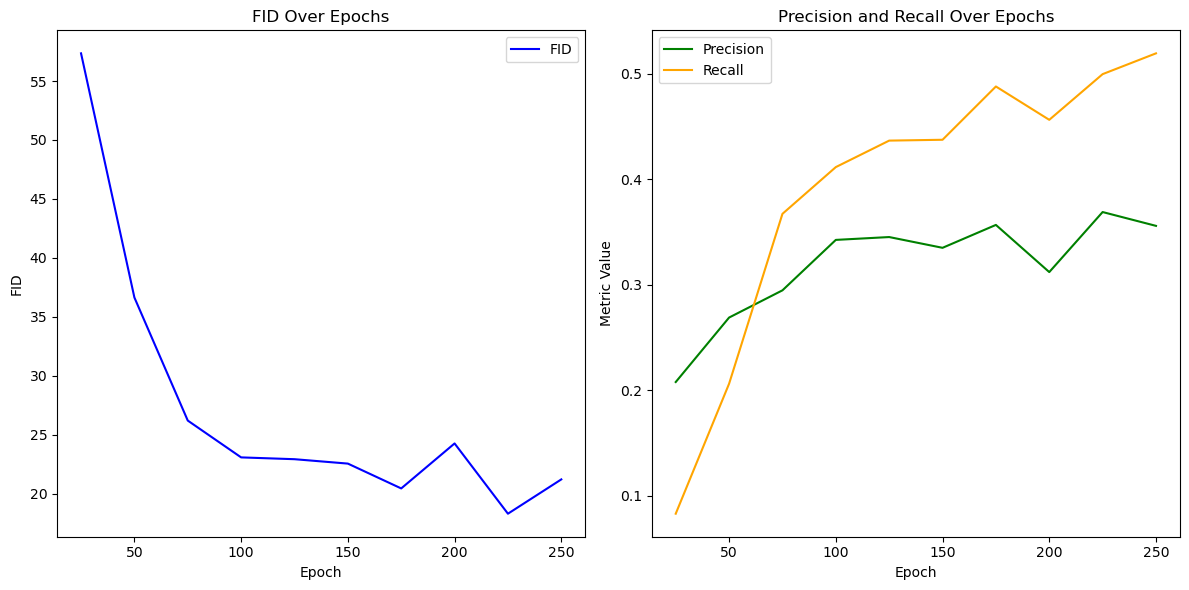

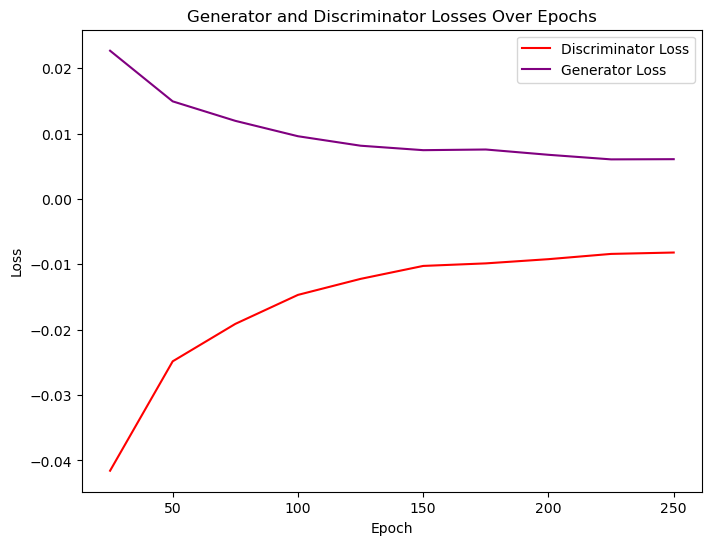

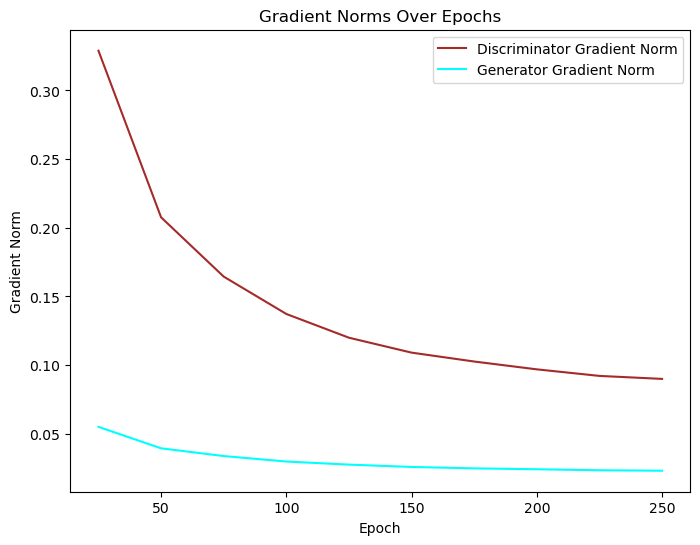

In [ ]:
from scipy.ndimage import gaussian_filter1d

# Create smoothed versions of the metrics
smooth_fids = gaussian_filter1d(fids, sigma=1.0)
smooth_precisions = gaussian_filter1d(precisions, sigma=1.0)
smooth_recalls = gaussian_filter1d(recalls, sigma=1.0)
smooth_d_losses = gaussian_filter1d(np.abs(d_losses), sigma=1.0)
smooth_g_losses = gaussian_filter1d(g_losses, sigma=1.0)
smooth_d_grad_norms = gaussian_filter1d(d_grad_norms, sigma=1.0)
smooth_g_grad_norms = gaussian_filter1d(g_grad_norms, sigma=1.0)

# Plot losses with smoothed curves
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.semilogy(epochs, np.abs(d_losses), 'o-', alpha=0.3, color='red', label='Original')
plt.semilogy(epochs, smooth_d_losses, '-', color='red', linewidth=2, label='Smoothed')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Discriminator Loss (Semilogarithmic Scale)')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.subplot(1, 2, 2)
plt.semilogy(epochs, g_losses, 'o-', alpha=0.3, color='purple', label='Original')
plt.semilogy(epochs, smooth_g_losses, '-', color='purple', linewidth=2, label='Smoothed')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Generator Loss (Semilogarithmic Scale)')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Plot smoothed FID, Precision, and Recall
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, fids, 'o-', alpha=0.3, color='blue', label='Original')
plt.plot(epochs, smooth_fids, '-', color='blue', linewidth=2, label='Smoothed')
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.title('FID Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, precisions, 'o-', alpha=0.3, color='green', label='Original Precision')
plt.plot(epochs, recalls, 'o-', alpha=0.3, color='orange', label='Original Recall')
plt.plot(epochs, smooth_precisions, '-', color='green', linewidth=2, label='Smoothed Precision')
plt.plot(epochs, smooth_recalls, '-', color='orange', linewidth=2, label='Smoothed Recall')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Precision and Recall Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Plot smoothed gradient norms
plt.figure(figsize=(8, 6))
plt.plot(epochs, d_grad_norms, 'o-', alpha=0.3, color='brown', label='Original D Grad Norm')
plt.plot(epochs, g_grad_norms, 'o-', alpha=0.3, color='cyan', label='Original G Grad Norm')
plt.plot(epochs, smooth_d_grad_norms, '-', color='brown', linewidth=2, label='Smoothed D Grad Norm')
plt.plot(epochs, smooth_g_grad_norms, '-', color='cyan', linewidth=2, label='Smoothed G Grad Norm')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms Over Epochs')
plt.legend()
plt.show()


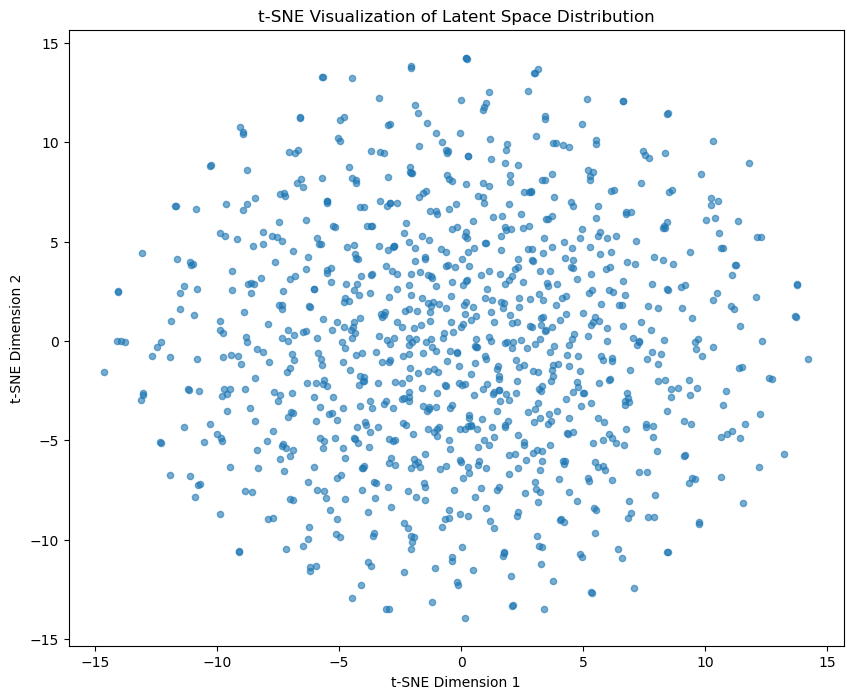

In [6]:
from sklearn.manifold import TSNE

def visualize_latent_distribution(G, device, num_samples=1000, latent_dim=100, save_path=None):
    """
    Visualize the distribution of latent vectors and their relationships.
    
    Args:
        G (torch.nn.Module): The generator model.
        device (torch.device): The device to run the generator on.
        num_samples (int): Number of latent vectors to sample.
        latent_dim (int): Dimensionality of the latent space.
        save_path (str): Optional path to save the visualization.
    """
    G.eval()
    
    # Sample random latent vectors
    z = torch.randn(num_samples, latent_dim).to(device)
    
    # Apply t-SNE directly to latent vectors (not generated images)
    z_2d = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(z.cpu().numpy())
    
    # Plot the latent space distribution
    plt.figure(figsize=(10, 8))
    plt.scatter(z_2d[:, 0], z_2d[:, 1], alpha=0.6, s=20)
    plt.title('t-SNE Visualization of Latent Space Distribution')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Latent distribution visualization saved to {save_path}")
    else:
        plt.show()
    
    G.train()

# Visualize latent space distribution
visualize_latent_distribution(G, device, num_samples=1000, latent_dim=100)


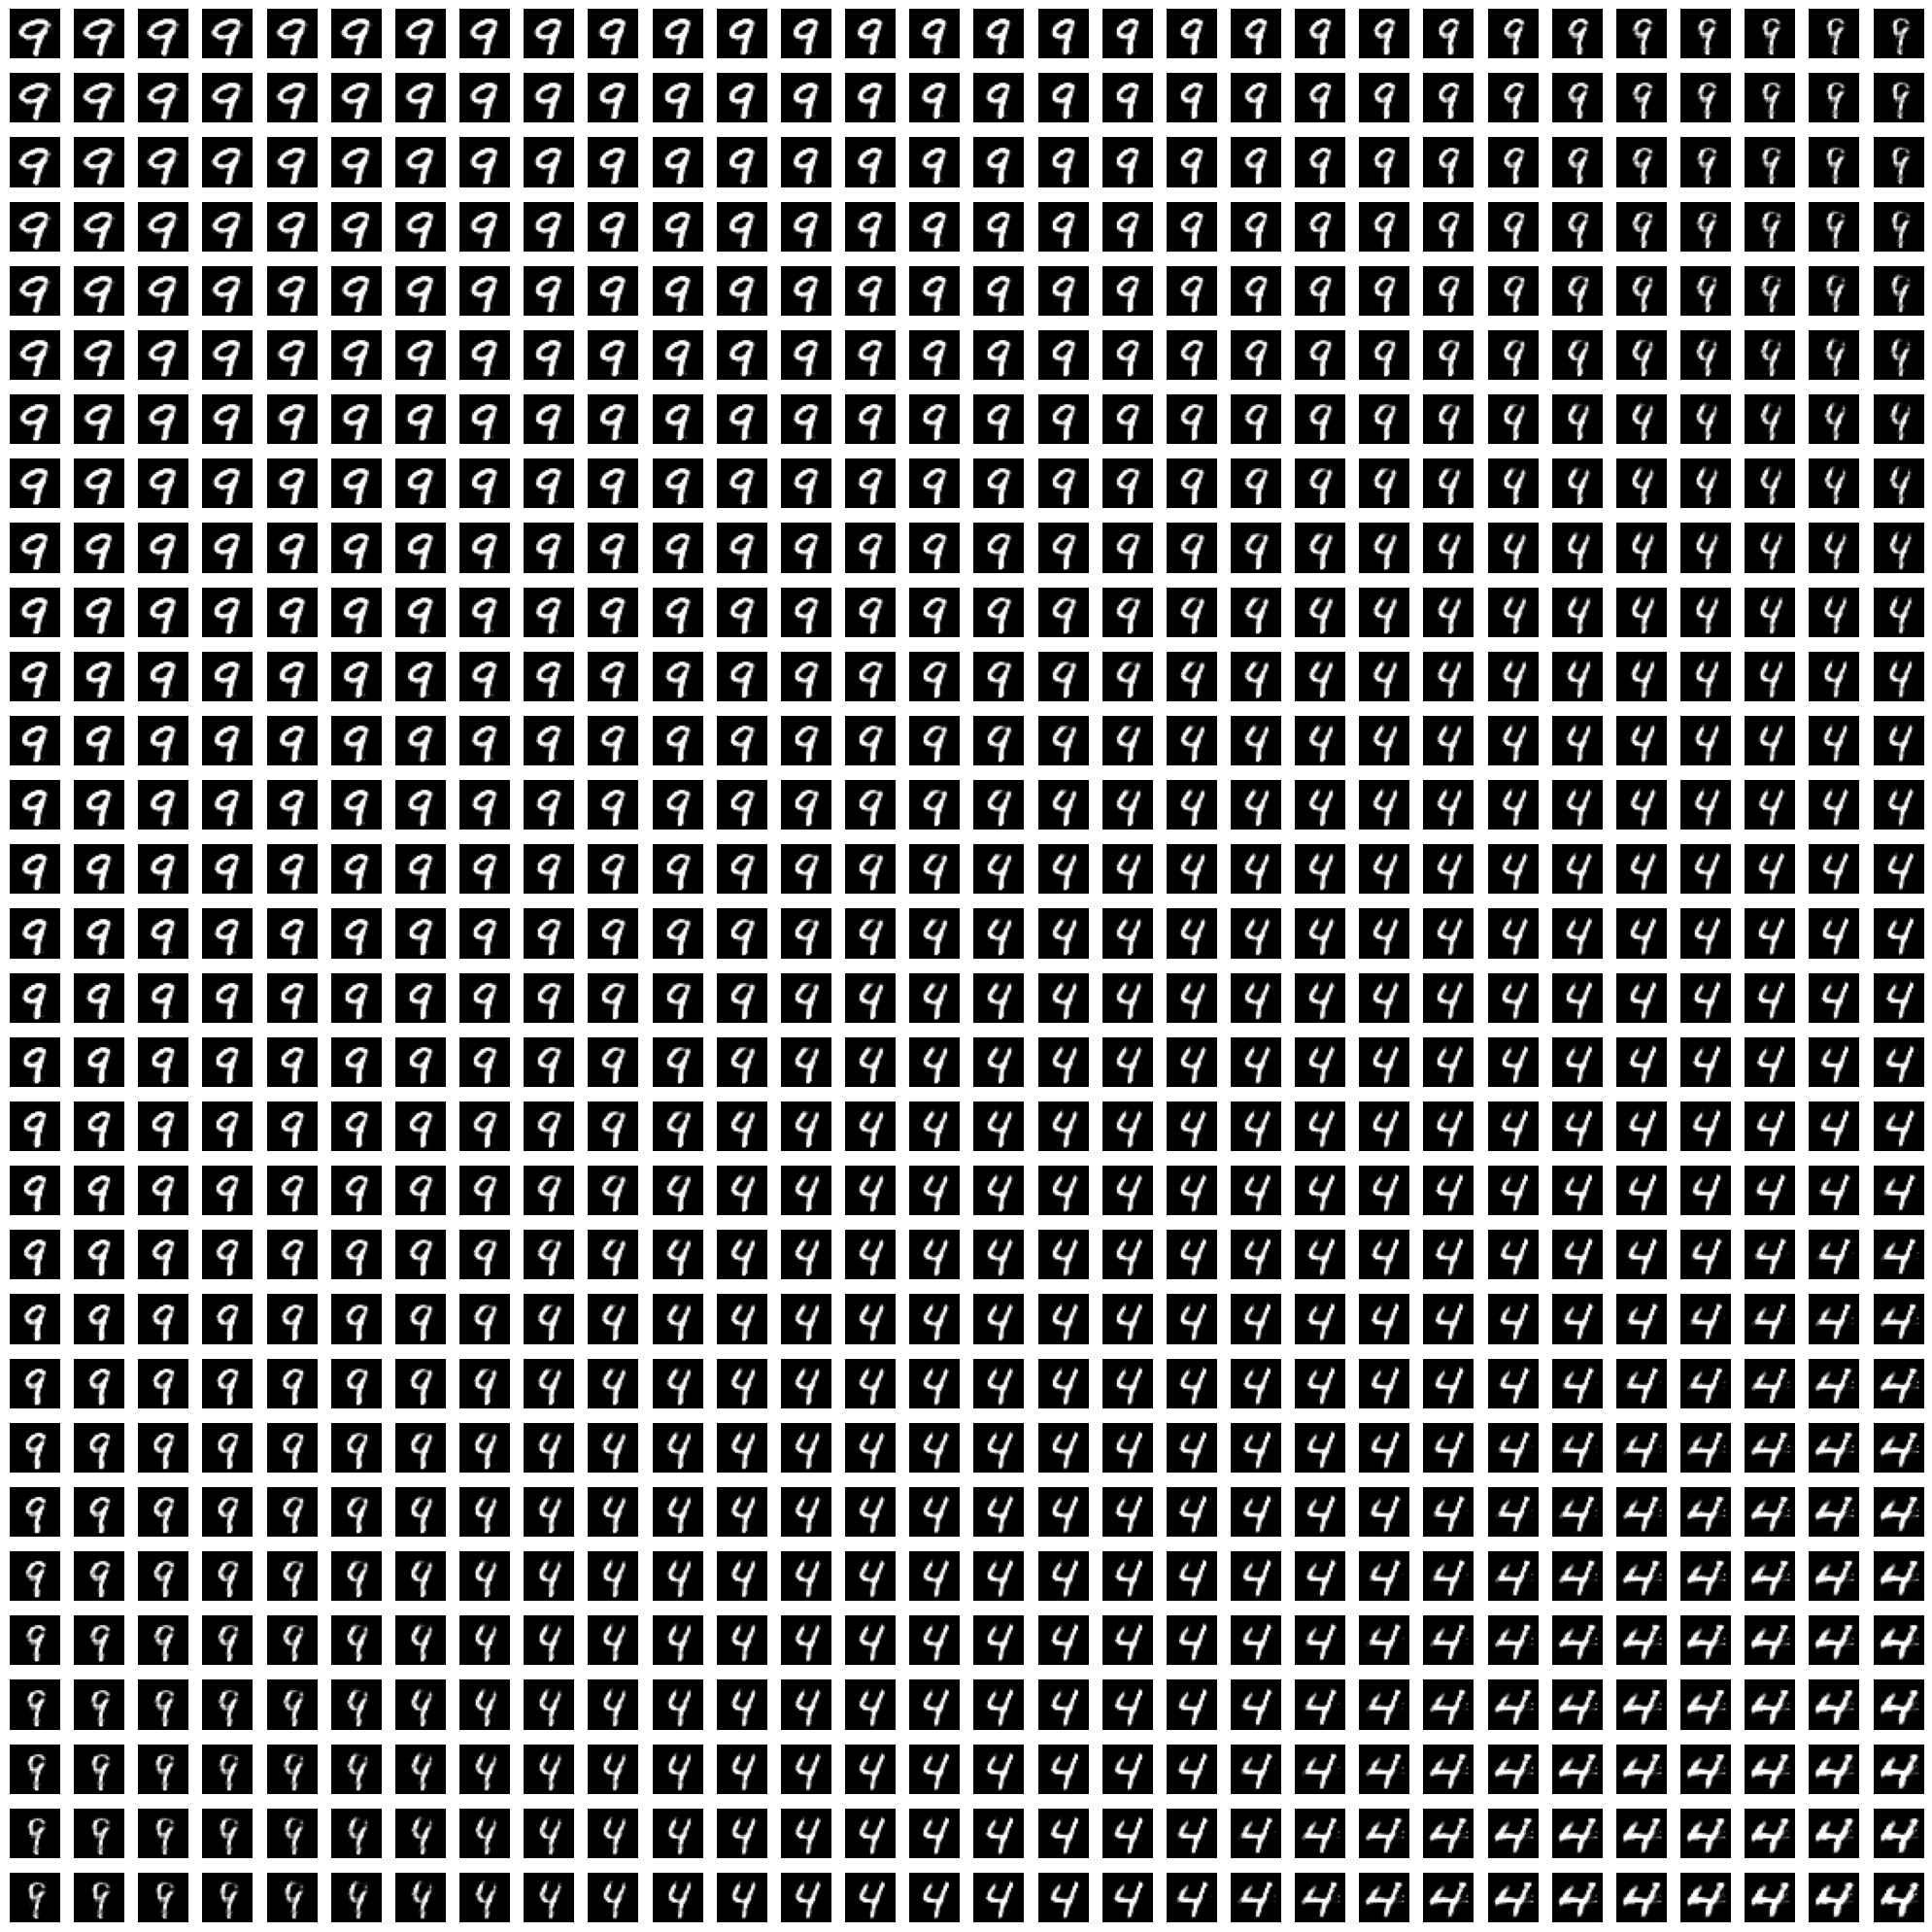

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from model import Generator
from utils import load_model

mnist_dim = 784

device = "cuda" if torch.cuda.is_available() else "cpu"
G = Generator(g_output_dim=mnist_dim).to(device)
G = load_model(G, 'checkpoints', device)

def visualize_latent_space(G, device, grid_size=10, latent_dim=100, save_path=None):
    """
    Visualize the latent space of the generator by interpolating between points.

    Args:
        G (torch.nn.Module): The generator model.
        device (torch.device): The device to run the generator on.
        grid_size (int): The number of rows and columns in the grid.
        latent_dim (int): The dimensionality of the latent space.
        save_path (str): Optional path to save the visualization. If None, the plot is shown.
    """
    G.eval()  # Set the generator to evaluation mode

    # Generate two random points in the latent space
    z1 = torch.randn(1, latent_dim).to(device)
    z2 = torch.randn(1, latent_dim).to(device)

    # Interpolate between the two points
    z_grid = torch.zeros(grid_size, grid_size, latent_dim).to(device)
    for i in range(grid_size):
        for j in range(grid_size):
            alpha = i / (grid_size - 1)
            beta = j / (grid_size - 1)
            z_grid[i, j] = (1 - alpha) * (1 - beta) * z1 + alpha * beta * z2

    # Flatten the grid and pass through the generator
    z_grid = z_grid.view(-1, latent_dim)
    with torch.no_grad():
        generated_images = G(z_grid).reshape(-1, 28, 28).cpu()

    # Normalize the images to [0, 1] for visualization
    generated_images = (generated_images + 1) / 2

    # Plot the grid of images
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))
    for i in range(grid_size):
        for j in range(grid_size):
            axes[i, j].imshow(generated_images[i * grid_size + j], cmap='gray')
            axes[i, j].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Latent space visualization saved to {save_path}")
    else:
        plt.show()

    G.train()  # Set the generator back to training mode

# Example usage
visualize_latent_space(G, device, grid_size=30, latent_dim=100)